# Project 2 - Predict House Price, by Chenhao Andy Xu

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn import metrics

## 1. Load and Check the Data

In [161]:
train = pd.read_csv('./datasets/train.csv', keep_default_na = False, na_values = '')
test = pd.read_csv('./datasets/test.csv', keep_default_na = False, na_values = '')

In [162]:
train.shape, test.shape

((2051, 81), (878, 80))

In [163]:
# Retrieve the column which test data set does not have
set(train.columns) - set(test.columns)

{'SalePrice'}

In [164]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [165]:
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [166]:
train.isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Exposure       4
BsmtFin Type 2      2
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Cond         1
Bsmt Qual           1
Garage Finish       1
Garage Cars         1
Garage Area         1
Garage Qual         1
Total Bsmt SF       1
BsmtFin Type 1      1
Bsmt Cond           1
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
dtype: int64

In [167]:
test.isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

Lot Frontage     160
Garage Yr Blt     45
Garage Finish      1
Mas Vnr Area       1
Mas Vnr Type       1
Electrical         1
dtype: int64

In [168]:
train.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 81, dtype: object

## 2. Data Cleaning

### 2.1. Data Cleaning: Initial

In [169]:
# Add new columns to determine how old the house is when being sold
train['house_age_built'] = train['Yr Sold'] - train['Year Built']
train['house_age_remodel'] = train['Yr Sold'] - train['Year Remod/Add']

test['house_age_built'] = test['Yr Sold'] - test['Year Built']
test['house_age_remodel'] = test['Yr Sold'] - test['Year Remod/Add']

In [170]:
# Delete columns that either have nothing to do with price or useless columns 
train.drop(columns = ['PID', 'Yr Sold', 'Year Built', 'Year Remod/Add'], inplace = True)
test.drop(columns = ['PID', 'Yr Sold', 'Year Built', 'Year Remod/Add'], inplace = True)

In [171]:
train.shape, test.shape

((2051, 79), (878, 78))

In [172]:
# Convert rating columns to numeric
# EX: 5, Gd: 4, TA: 3, Fa: 2, Po: 1

def convert_rate(rating):
        if rating == 'Ex':
            return 5
        elif rating == 'Gd':
            return 4
        elif rating == 'TA':
            return 3
        elif rating == 'Fa':
            return 2
        elif rating == 'Po':
            return 1

In [173]:
adj_col = []
for col in train.columns:
    if 'TA' in list(train[col]):    
        adj_col.append(col)
adj_col

['Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Heating QC',
 'Kitchen Qual',
 'Fireplace Qu',
 'Garage Qual',
 'Garage Cond',
 'Pool QC']

In [174]:
for col in adj_col:
    train[col] = train[col].apply(convert_rate)

In [175]:
# Convert Yes/No columns to be numeric
train['Central Air'] = train['Central Air'].replace('Y', 1)
train['Central Air'] = train['Central Air'].replace('N', 0)

train['Paved Drive'] = train['Paved Drive'].replace('Y', 1)
train['Paved Drive'] = train['Paved Drive'].replace('P', 0.5)
train['Paved Drive'] = train['Paved Drive'].replace('N', 0)

In [176]:
adj_col = []
for col in test.columns:
    if 'TA' in list(test[col]):    
        adj_col.append(col)
for col in adj_col:
    test[col] = test[col].apply(convert_rate)

In [177]:
test['Central Air'] = test['Central Air'].replace('Y', 1)
test['Central Air'] = test['Central Air'].replace('N', 0)

test['Paved Drive'] = test['Paved Drive'].replace('Y', 1)
test['Paved Drive'] = test['Paved Drive'].replace('P', 0.5)
test['Paved Drive'] = test['Paved Drive'].replace('N', 0)

In [178]:
train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace( ' ', '_')

In [179]:
train.shape, test.shape

((2051, 79), (878, 78))

### 2.2. Data Cleaning: Split Data

In [182]:
X = train.drop(columns = ['saleprice'])
y = train['saleprice']

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

We will use X_train for creating the model and X_val for validating the model

In [184]:
X_train.shape, X_val.shape, test.shape

((1640, 78), (411, 78), (878, 78))

In [185]:
X_train.head()

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,sale_type,house_age_built,house_age_remodel
1448,452,120,RL,47.0,6904,Pave,NA,IR1,Lvl,AllPub,...,0,0,NaN,NA,NA,0,8,WD,4,4
1771,1697,20,RL,110.0,14226,Pave,NA,Reg,Lvl,AllPub,...,0,0,NaN,NA,NA,0,7,New,1,1
966,2294,80,RL,NaN,15957,Pave,NA,IR1,Low,AllPub,...,0,0,NaN,MnPrv,NA,0,9,WD,30,30
1604,2449,60,RL,93.0,12090,Pave,NA,Reg,Lvl,AllPub,...,0,0,NaN,NA,NA,0,7,WD,8,8
1827,1859,80,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,0,NaN,NA,NA,0,8,WD,31,13


### 2.3. Data Cleaning: Separate Numeric and Obejct Data Columns

In [186]:
# There are still so many columns, let's separate numeric and object columns. Numeric columns can be edited directly and object columns are required to dummfied. 
train.dtypes.value_counts()

int64      31
object     30
float64    18
dtype: int64

In [187]:
test.dtypes.value_counts()

int64      38
object     30
float64    10
dtype: int64

In [188]:
X_train_num = X_train._get_numeric_data()

In [189]:
X_train_obj = X_train[X_train.dtypes[X_train.dtypes == 'object'].index]

In [190]:
X_val_num = X_val._get_numeric_data()

In [191]:
X_val_obj = X_val[X_val.dtypes[X_val.dtypes == 'object'].index]

In [192]:
test_num = test._get_numeric_data()

In [193]:
test_obj = test[test.dtypes[test.dtypes == 'object'].index]

In [194]:
X_train_num.shape, X_train_obj.shape

((1640, 48), (1640, 30))

In [195]:
X_val_num.shape, X_val_obj.shape

((411, 48), (411, 30))

In [196]:
test_num.shape, test_obj.shape

((878, 48), (878, 30))

#### 2.3.1. Deal with Numeric Columns

Since there are still too many numeric columns. we'd select columns by the coorelation with the saleprice. 
However, the X_train set doesn't have saleprice. We'd go back to combine X_train and y_train and then analyze the correlations with saleprice. 

In [197]:
X_train_price = pd.concat([X_train_num, y_train], axis = 1)

In [198]:
X_train_price.head()

,id,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,misc_val,mo_sold,house_age_built,house_age_remodel,saleprice
1448,452,120,47.0,6904,6,5,240.0,4,3,4.0,...,0,0,0,0,NaN,0,8,4,4,213000
1771,1697,20,110.0,14226,8,5,375.0,4,3,4.0,...,0,0,0,0,NaN,0,7,1,1,395000
966,2294,80,NaN,15957,6,6,0.0,3,3,4.0,...,0,0,0,0,NaN,0,9,30,30,188000
1604,2449,60,93.0,12090,8,5,650.0,4,3,4.0,...,0,0,0,0,NaN,0,7,8,8,258000
1827,1859,80,80.0,9600,6,7,360.0,4,4,3.0,...,0,0,0,0,NaN,0,8,31,13,187000


In [199]:
# Stash the id columns away
train_id = X_train['id']
val_id = X_val['id']
test_id = test['id']

In [200]:
corr_X_train_num = X_train_price.corr()['saleprice'].abs()
corr_X_train_num.sort_values()

misc_val             0.008064
pool_area            0.014399
bsmtfin_sf_2         0.018644
bsmt_half_bath       0.033608
exter_cond           0.034141
low_qual_fin_sf      0.034890
mo_sold              0.041451
3ssn_porch           0.054876
id                   0.066641
ms_subclass          0.089512
overall_cond         0.104320
kitchen_abvgr        0.115706
enclosed_porch       0.136301
bedroom_abvgr        0.137312
screen_porch         0.141524
garage_cond          0.143116
bsmt_unf_sf          0.171787
bsmt_cond            0.174590
garage_qual          0.216395
2nd_flr_sf           0.254016
central_air          0.267711
half_bath            0.283829
paved_drive          0.291192
bsmt_full_bath       0.296780
wood_deck_sf         0.303756
fireplace_qu         0.316914
lot_frontage         0.331902
lot_area             0.335916
open_porch_sf        0.337123
pool_qc              0.380671
bsmtfin_sf_1         0.424711
heating_qc           0.467374
fireplaces           0.470765
totrms_abv

Notice: id column is filtered out since the minimum requirement of correlation score is 0.45. So, we don't need to worry about it and we can add id column later on. 

In [201]:
df_X_train_corr = pd.DataFrame(corr_X_train_num.sort_values())
df_X_train_corr = df_X_train_corr.reset_index()
df_X_train_corr.columns = ['Column Type', 'Correlation Score with Price']

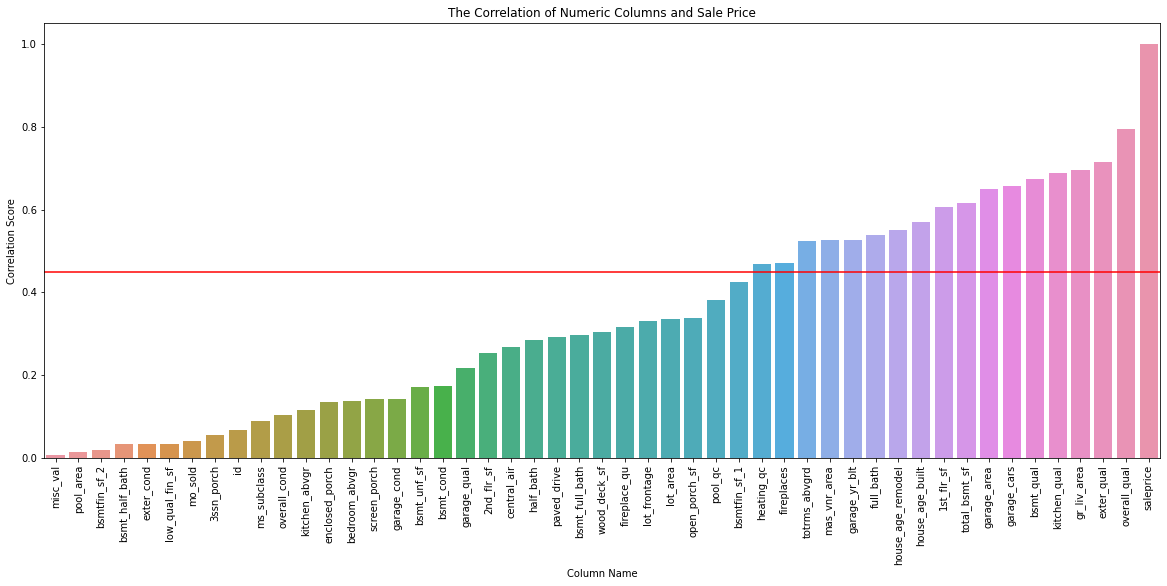

In [202]:
plt.figure(figsize = (20,8))
sns.barplot(data = df_X_train_corr, x = 'Column Type', y = 'Correlation Score with Price')
plt.axhline(y = 0.45, c = 'red')
plt.xticks(rotation = 90);
plt.title('The Correlation of Numeric Columns and Sale Price')
plt.xlabel('Column Name')
plt.ylabel('Correlation Score');
plt.savefig('./images/Column_Selecton_Numeric.jpg');

In [203]:
# Select columns that have more than 0.45 coorelation with saleprice. 

X_train_num = X_train_num[corr_X_train_num[(corr_X_train_num > 0.45) & (corr_X_train_num < 1.0)].index]

X_val_num = X_val_num[corr_X_train_num[(corr_X_train_num > 0.45) & (corr_X_train_num < 1.0)].index]

test_num = test_num[corr_X_train_num[(corr_X_train_num > 0.45) & (corr_X_train_num < 1.0)].index]

In [204]:
X_train_num.isnull().sum()

overall_qual          0
mas_vnr_area         19
exter_qual            0
bsmt_qual            41
total_bsmt_sf         1
heating_qc            0
1st_flr_sf            0
gr_liv_area           0
full_bath             0
kitchen_qual          0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt        93
garage_cars           0
garage_area           0
house_age_built       0
house_age_remodel     0
dtype: int64

In [205]:
X_val_num.isnull().sum()

overall_qual          0
mas_vnr_area          3
exter_qual            0
bsmt_qual            14
total_bsmt_sf         0
heating_qc            0
1st_flr_sf            0
gr_liv_area           0
full_bath             0
kitchen_qual          0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt        21
garage_cars           1
garage_area           1
house_age_built       0
house_age_remodel     0
dtype: int64

In [206]:
test_num.isnull().sum()

overall_qual          0
mas_vnr_area          1
exter_qual            0
bsmt_qual            25
total_bsmt_sf         0
heating_qc            0
1st_flr_sf            0
gr_liv_area           0
full_bath             0
kitchen_qual          0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt        45
garage_cars           0
garage_area           0
house_age_built       0
house_age_remodel     0
dtype: int64

In [207]:
# Delete columns have too many missing values, filter rule: more than 5% of the missing values
X_train_num = X_train_num.drop(columns = ['garage_yr_blt'])

X_val_num = X_val_num.drop(columns = ['garage_yr_blt'])

test_num = test_num.drop(columns = ['garage_yr_blt'])

In [208]:
# Add id column back to the dataset
X_train_num = pd.concat([train_id, X_train_num], axis = 1)
X_val_num = pd.concat([val_id, X_val_num], axis = 1)
test_num = pd.concat([test_id, test_num], axis = 1)

In [209]:
X_train_num.shape, X_val_num.shape, test_num.shape

((1640, 17), (411, 17), (878, 17))

#### 2.3.2. Deal with Object Columns

In [210]:
X_train_obj.isna().sum().sort_values(ascending = False)

mas_vnr_type      19
bsmt_exposure      4
bsmtfin_type_2     2
bsmtfin_type_1     1
ms_zoning          0
street             0
misc_feature       0
fence              0
garage_finish      0
garage_type        0
functional         0
electrical         0
heating            0
foundation         0
exterior_2nd       0
exterior_1st       0
roof_matl          0
roof_style         0
house_style        0
bldg_type          0
condition_2        0
condition_1        0
neighborhood       0
land_slope         0
lot_config         0
utilities          0
land_contour       0
lot_shape          0
alley              0
sale_type          0
dtype: int64

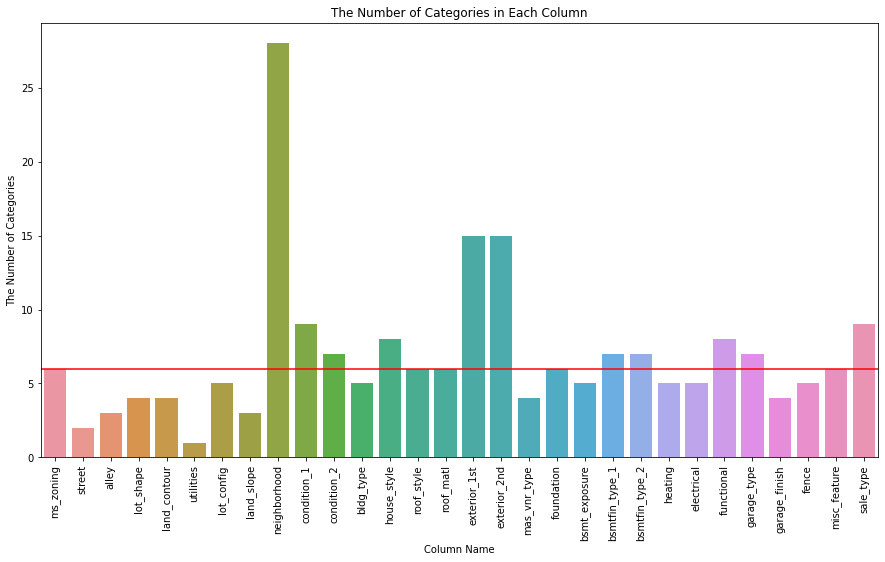

In [211]:
types = []
for col in (X_train_obj.columns):
    types.append(len(X_train_obj[col].value_counts()))
types = pd.DataFrame(types)
X_train_obj_col = pd.DataFrame(X_train_obj.columns)
Col_cate = pd.concat([X_train_obj_col, types], axis = 1)
Col_cate.columns = ['Column Name', 'Number of Categories']

plt.figure(figsize = (15,8))
sns.barplot(data = Col_cate, x = 'Column Name', y = 'Number of Categories')
plt.axhline(y = 6, c = 'red')
plt.xticks(rotation = 90);
plt.title('The Number of Categories in Each Column')
plt.xlabel('Column Name')
plt.ylabel('The Number of Categories');
plt.savefig('./images/Column_Selecton_Object.jpg');

In [212]:
X_train_obj_col = pd.DataFrame(X_train_obj.columns)

In [213]:
for col in (X_train_obj.columns):
    if len(X_train_obj[col].value_counts()) > 6:
        X_train_obj.drop(columns = col, inplace = True)
X_train_obj.shape

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1640, 19)

In [214]:
X_train_obj = pd.concat([X_train_obj, X_train['neighborhood']], axis = 1) 
X_train_obj

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,bldg_type,roof_style,roof_matl,mas_vnr_type,foundation,bsmt_exposure,heating,electrical,garage_finish,fence,misc_feature,neighborhood
1448,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,TwnhsE,Gable,CompShg,Stone,PConc,Av,GasA,SBrkr,RFn,NA,NA,NridgHt
1771,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,1Fam,Hip,CompShg,BrkFace,PConc,Av,GasA,SBrkr,Fin,NA,NA,NridgHt
966,RL,Pave,NA,IR1,Low,AllPub,Corner,Mod,1Fam,Gable,CompShg,None,PConc,Gd,GasA,SBrkr,Fin,MnPrv,NA,Mitchel
1604,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,1Fam,Hip,CompShg,BrkFace,PConc,No,GasA,SBrkr,Fin,NA,NA,NoRidge
1827,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,1Fam,Hip,CompShg,BrkFace,CBlock,No,GasA,SBrkr,RFn,NA,NA,Veenker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,1Fam,Gable,CompShg,Stone,PConc,Gd,GasA,SBrkr,Fin,NA,NA,NridgHt
1095,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,CompShg,BrkFace,CBlock,No,GasA,FuseA,RFn,NA,NA,NAmes
1130,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Hip,CompShg,BrkFace,CBlock,No,GasA,SBrkr,RFn,GdPrv,NA,NWAmes
1294,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Twnhs,Gable,CompShg,BrkFace,CBlock,No,GasA,SBrkr,Unf,NA,NA,BrDale


In [215]:
X_train_obj.isna().sum().sort_values(ascending = False)

mas_vnr_type     19
bsmt_exposure     4
ms_zoning         0
street            0
misc_feature      0
fence             0
garage_finish     0
electrical        0
heating           0
foundation        0
roof_matl         0
roof_style        0
bldg_type         0
land_slope        0
lot_config        0
utilities         0
land_contour      0
lot_shape         0
alley             0
neighborhood      0
dtype: int64

In [216]:
# Delete columns have too many missing values, filter rule: more than 5% of the missing values
# 5% of 160  = 82. So no rows should be deleted. 

In [217]:
col_list = []
for col in X_train_obj.columns:
    col_list.append(col) 
X_val_obj = X_val_obj.loc[:, col_list]

X_val_obj.isna().sum().sort_values(ascending = False)

mas_vnr_type     3
garage_finish    1
ms_zoning        0
street           0
misc_feature     0
fence            0
electrical       0
heating          0
bsmt_exposure    0
foundation       0
roof_matl        0
roof_style       0
bldg_type        0
land_slope       0
lot_config       0
utilities        0
land_contour     0
lot_shape        0
alley            0
neighborhood     0
dtype: int64

In [218]:
col_list = []
for col in X_train_obj.columns:
    col_list.append(col) 
test_obj = test_obj.loc[:, col_list]

test_obj.isna().sum().sort_values(ascending = False)

garage_finish    1
electrical       1
mas_vnr_type     1
ms_zoning        0
street           0
misc_feature     0
fence            0
heating          0
bsmt_exposure    0
foundation       0
roof_matl        0
roof_style       0
bldg_type        0
land_slope       0
lot_config       0
utilities        0
land_contour     0
lot_shape        0
alley            0
neighborhood     0
dtype: int64

In [219]:
X_train_obj.shape, X_val_obj.shape, test_obj.shape

((1640, 20), (411, 20), (878, 20))

#### 2.3.3. Combine Numeric and Object Dataset

In [220]:
X_train = pd.concat([X_train_num, X_train_obj], axis = 1)
X_train.head()

,id,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,heating_qc,1st_flr_sf,gr_liv_area,full_bath,...,roof_matl,mas_vnr_type,foundation,bsmt_exposure,heating,electrical,garage_finish,fence,misc_feature,neighborhood
1448,452,6,240.0,4,4.0,1358.0,5,1358,1358,2,...,CompShg,Stone,PConc,Av,GasA,SBrkr,RFn,NA,NA,NridgHt
1771,1697,8,375.0,4,4.0,1935.0,4,1973,1973,2,...,CompShg,BrkFace,PConc,Av,GasA,SBrkr,Fin,NA,NA,NridgHt
966,2294,6,0.0,3,4.0,1244.0,3,1356,1356,2,...,CompShg,None,PConc,Gd,GasA,SBrkr,Fin,MnPrv,NA,Mitchel
1604,2449,8,650.0,4,4.0,1141.0,4,1165,2263,2,...,CompShg,BrkFace,PConc,No,GasA,SBrkr,Fin,NA,NA,NoRidge
1827,1859,6,360.0,4,3.0,528.0,5,1094,1855,2,...,CompShg,BrkFace,CBlock,No,GasA,SBrkr,RFn,NA,NA,Veenker


In [221]:
X_val = pd.concat([X_val_num, X_val_obj], axis = 1)
X_val.head()

,id,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,heating_qc,1st_flr_sf,gr_liv_area,full_bath,...,roof_matl,mas_vnr_type,foundation,bsmt_exposure,heating,electrical,garage_finish,fence,misc_feature,neighborhood
1124,2782,5,0.0,3,3.0,911.0,4,954,954,1,...,CompShg,None,CBlock,Av,GasA,SBrkr,Unf,NA,NA,CollgCr
188,2569,7,309.0,3,3.0,924.0,5,1216,2157,2,...,CompShg,BrkFace,CBlock,No,GasA,SBrkr,Fin,GdPrv,NA,NAmes
1727,1062,8,108.0,5,4.0,948.0,5,948,2088,2,...,CompShg,Stone,PConc,Av,GasA,SBrkr,Fin,NA,NA,NridgHt
1658,287,6,0.0,3,4.0,806.0,3,841,1647,1,...,CompShg,None,PConc,No,GasA,FuseF,Unf,NA,NA,SWISU
1424,2809,7,0.0,4,4.0,851.0,5,851,1737,2,...,CompShg,None,PConc,Mn,GasA,SBrkr,RFn,NA,NA,CollgCr


In [222]:
test = pd.concat([test_num, test_obj], axis = 1)
test.head()

,id,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,heating_qc,1st_flr_sf,gr_liv_area,full_bath,...,roof_matl,mas_vnr_type,foundation,bsmt_exposure,heating,electrical,garage_finish,fence,misc_feature,neighborhood
0,2658,6,0.0,3,2.0,1020,4,908,1928,2,...,CompShg,None,Stone,No,GasA,FuseP,Unf,NA,NA,OldTown
1,2718,5,0.0,3,4.0,1967,3,1967,1967,2,...,CompShg,None,CBlock,No,GasA,SBrkr,Fin,NA,NA,Sawyer
2,2414,7,0.0,4,4.0,654,5,664,1496,2,...,CompShg,None,PConc,Av,GasA,SBrkr,RFn,NA,NA,Gilbert
3,1989,5,0.0,4,3.0,968,3,968,968,1,...,CompShg,None,CBlock,No,GasA,SBrkr,Unf,NA,NA,OldTown
4,625,6,247.0,3,4.0,1394,4,1394,1394,1,...,CompShg,BrkFace,CBlock,No,GasA,SBrkr,RFn,NA,NA,NAmes


In [223]:
X_train.isna().sum().sum(), X_val.isna().sum().sum(), test.isna().sum().sum()

(84, 23, 29)

In [224]:
X_train.shape, X_val.shape, test.shape

((1640, 37), (411, 37), (878, 37))

### 2.4. Simple Imputer and OneHotEncoder

In [225]:
si = SimpleImputer(strategy = 'most_frequent')

In [226]:
X_train = si.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = si.feature_names_in_ )

In [227]:
X_val = si.transform(X_val)
X_val = pd.DataFrame(X_val, columns = si.feature_names_in_ )

In [228]:
test = si.transform(test)
test = pd.DataFrame(test, columns = si.feature_names_in_ )

In [229]:
X_train.isnull().sum().sum(), X_val.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0, 0)

In [230]:
X_train.head()

,id,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,heating_qc,1st_flr_sf,gr_liv_area,full_bath,...,roof_matl,mas_vnr_type,foundation,bsmt_exposure,heating,electrical,garage_finish,fence,misc_feature,neighborhood
0,452,6,240.0,4,4.0,1358.0,5,1358,1358,2,...,CompShg,Stone,PConc,Av,GasA,SBrkr,RFn,NA,NA,NridgHt
1,1697,8,375.0,4,4.0,1935.0,4,1973,1973,2,...,CompShg,BrkFace,PConc,Av,GasA,SBrkr,Fin,NA,NA,NridgHt
2,2294,6,0.0,3,4.0,1244.0,3,1356,1356,2,...,CompShg,None,PConc,Gd,GasA,SBrkr,Fin,MnPrv,NA,Mitchel
3,2449,8,650.0,4,4.0,1141.0,4,1165,2263,2,...,CompShg,BrkFace,PConc,No,GasA,SBrkr,Fin,NA,NA,NoRidge
4,1859,6,360.0,4,3.0,528.0,5,1094,1855,2,...,CompShg,BrkFace,CBlock,No,GasA,SBrkr,RFn,NA,NA,Veenker


In [231]:
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)

In [232]:
encoder = make_column_transformer(
    (ohe, col_list),
    remainder = 'passthrough', # don't drop other columns
    verbose_feature_names_out = False
)

In [233]:
X_train = encoder.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = encoder.get_feature_names_out())

In [234]:
X_val = encoder.transform(X_val)
X_val = pd.DataFrame(X_val, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [235]:
test = encoder.transform(test)
test = pd.DataFrame(test, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 5, 10, 11, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [236]:
X_train.shape, X_val.shape, test.shape

((1640, 110), (411, 110), (878, 110))

### 2.5. Polynomial Feature and Standard Scaler

In [237]:
# poly = PolynomialFeatures(degree = 2,
#                          interaction_only = True,
#                          include_bias = False)

# X_train = poly.fit_transform(X_train)
# X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

# X_val = poly.transform(X_val)
# X_val = pd.DataFrame(X_val, columns = poly.get_feature_names_out())

# test = poly.transform(test)
# test = pd.DataFrame(test, columns = poly.get_feature_names_out())

In [238]:
# X_train.shape, X_val.shape

In [239]:
# remove id column before Standard Scaler
train_id = X_train['id']
val_id = X_val['id']
test_id = test['id']

X_train = X_train.drop(columns = ['id'])
X_val = X_val.drop(columns = ['id'])
test = test.drop(columns = ['id'])

In [240]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())

X_val = ss.transform(X_val)
X_val = pd.DataFrame(X_val, columns = ss.get_feature_names_out())

test = ss.transform(test)
test = pd.DataFrame(test, columns = ss.get_feature_names_out())

In [241]:
X_train.shape, X_val.shape, test.shape

((1640, 109), (411, 109), (878, 109))

In [242]:
X_train = pd.concat([train_id, X_train], axis = 1)
X_val = pd.concat([val_id, X_val], axis = 1)
test = pd.concat([test_id, test], axis = 1)

In [243]:
X_train.head()

,id,ms_zoning_C (all),ms_zoning_FV,ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,street_Pave,alley_NA,alley_Pave,lot_shape_IR2,...,1st_flr_sf,gr_liv_area,full_bath,kitchen_qual,totrms_abvgrd,fireplaces,garage_cars,garage_area,house_age_built,house_age_remodel
0,452,-0.099258,-0.23812,-0.089388,0.5407,-0.426094,0.0553,0.278441,-0.17364,-0.158114,...,0.478981,-0.279707,0.760097,0.723473,-0.269843,0.649556,0.298359,0.048810,-1.056614,-0.932923
1,1697,-0.099258,-0.23812,-0.089388,0.5407,-0.426094,0.0553,0.278441,-0.17364,-0.158114,...,2.000532,0.936761,0.760097,0.723473,1.648695,0.649556,1.603182,1.925248,-1.155895,-1.076042
2,2294,-0.099258,-0.23812,-0.089388,0.5407,-0.426094,0.0553,0.278441,-0.17364,-0.158114,...,0.474033,-0.283663,0.760097,-0.782232,-0.269843,0.649556,0.298359,0.249693,-0.196181,0.307445
3,2449,-0.099258,-0.23812,-0.089388,0.5407,-0.426094,0.0553,0.278441,-0.17364,-0.158114,...,0.001486,1.510380,0.760097,0.723473,2.288208,0.649556,0.298359,-0.243385,-0.924240,-0.742097
4,1859,-0.099258,-0.23812,-0.089388,0.5407,-0.426094,0.0553,0.278441,-0.17364,-0.158114,...,-0.174173,0.703357,0.760097,-0.782232,0.369670,0.649556,0.298359,0.176645,-0.163087,-0.503565


## 3. Modeling

In [244]:
# remove id column before Modeling
train_id = X_train['id']
val_id = X_val['id']
test_id = test['id']

X_train = X_train.drop(columns = ['id'])
X_val = X_val.drop(columns = ['id'])
test = test.drop(columns = ['id'])

In [245]:
lr = LinearRegression()

In [246]:
lr.fit(X_train, y_train)

LinearRegression()

In [247]:
train_pred = lr.predict(X_train)

val_pred = lr.predict(X_val)

test_pred = lr.predict(test)

In [248]:
train_res = y_train - train_pred

val_res = y_val - val_pred

In [249]:
lr.score(X_train, y_train), lr.score(X_val, y_val)

(0.9084045595301697, 0.8876059170482813)

In [250]:
metrics.mean_squared_error(y_train, train_pred) ** 0.5, metrics.mean_squared_error(y_val, val_pred) ** 0.5

(24141.907389553162, 25841.656008786063)

In [251]:
cross_val_score(lr, X_train, y_train, scoring = 'r2')

array([ 8.90785016e-01, -1.43571219e+25, -6.00332999e+25, -1.67316640e+23,
       -6.59302630e+22])

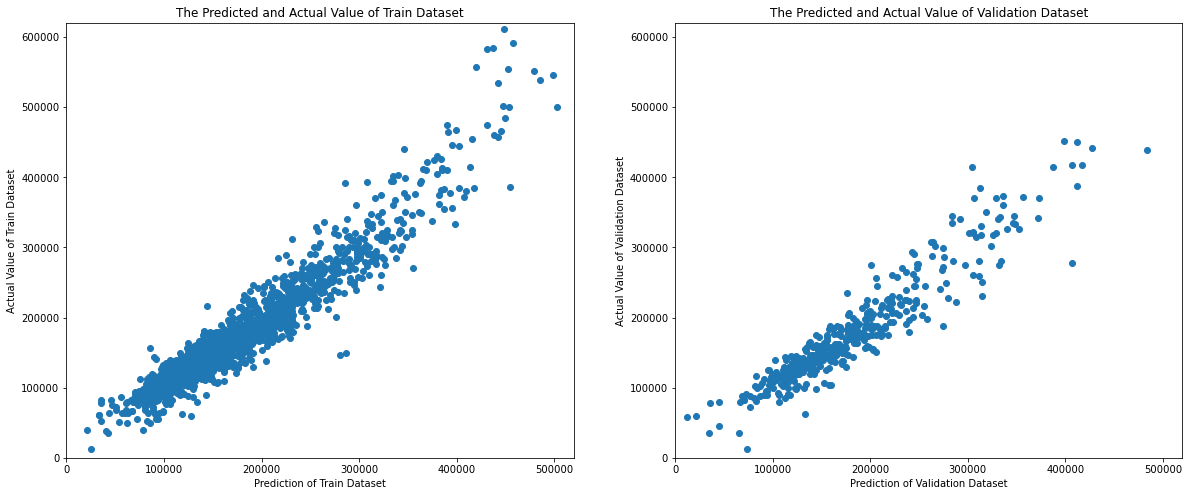

In [252]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
plt.scatter(x = train_pred, y = y_train)
plt.title('The Predicted and Actual Value of Train Dataset')
plt.xlabel('Prediction of Train Dataset')
plt.ylabel('Actual Value of Train Dataset')
plt.xlim(0, 520000)
plt.ylim(0, 620000)

plt.subplot(1, 2, 2)
plt.scatter(x = val_pred, y = y_val)
plt.title('The Predicted and Actual Value of Validation Dataset')
plt.xlabel('Prediction of Validation Dataset')
plt.ylabel('Actual Value of Validation Dataset')
plt.xlim(0, 520000)
plt.ylim(0, 620000);
plt.savefig('./images/lr_actual_pred.jpg');

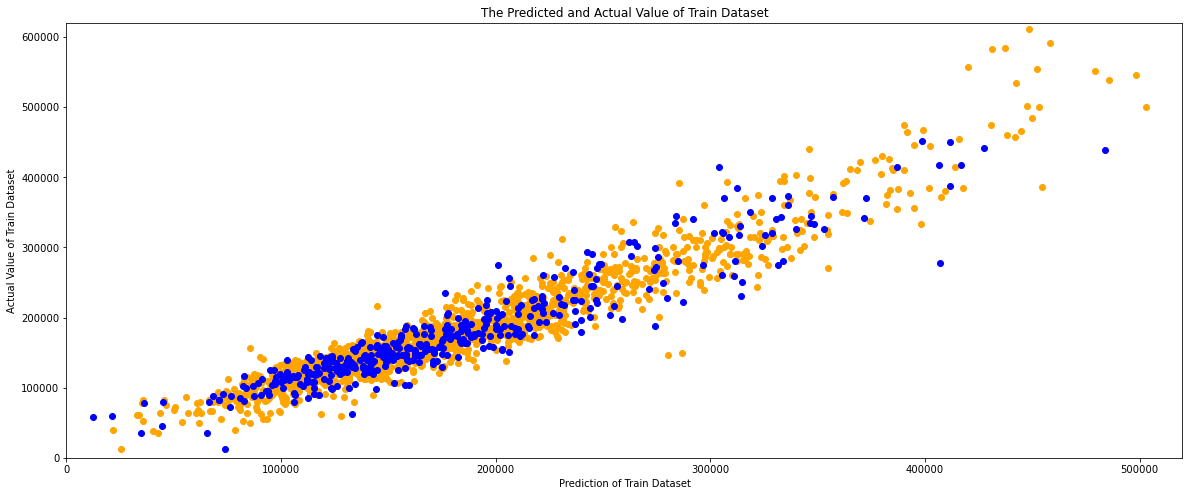

In [289]:
plt.figure(figsize = (20,8))
plt.scatter(x = train_pred, y = y_train, c = 'orange')
plt.scatter(x = val_pred, y = y_val, c = 'blue')
plt.title('The Predicted and Actual Value of Train Dataset')
plt.xlabel('Prediction of Train Dataset')
plt.ylabel('Actual Value of Train Dataset')
plt.xlim(0, 520000)
plt.ylim(0, 620000)
plt.savefig('./images/lr_toge_actual_pred.jpg');

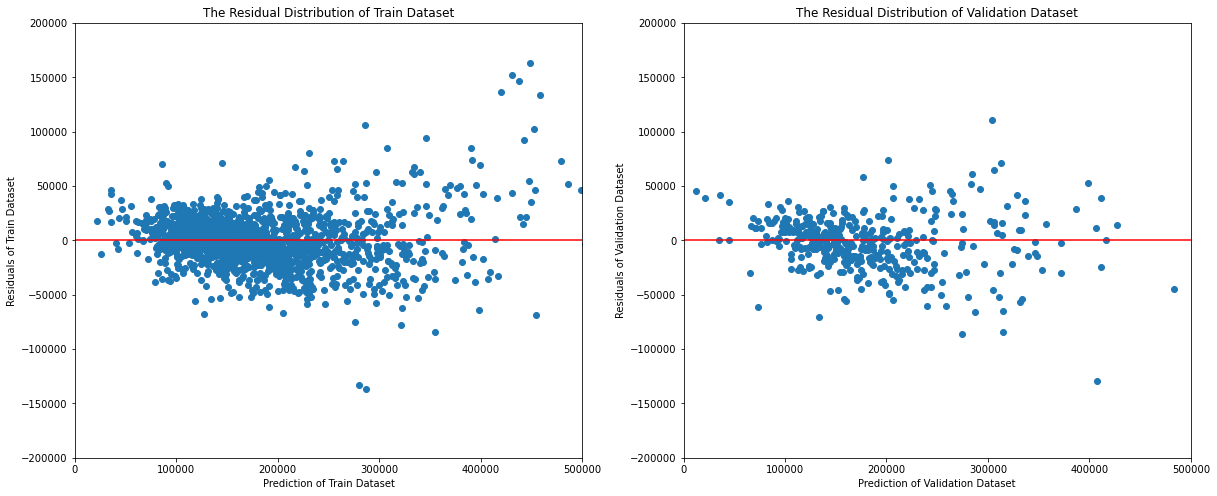

In [254]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.scatter(train_pred, train_res)
plt.axhline(0, color='red')
plt.title('The Residual Distribution of Train Dataset')
plt.xlabel('Prediction of Train Dataset')
plt.ylabel('Residuals of Train Dataset')
plt.xlim(0, 500000)
plt.ylim(-200000, 200000)

plt.subplot(1, 2, 2)
plt.scatter(val_pred, val_res)
plt.axhline(0, color='red')
plt.title('The Residual Distribution of Validation Dataset')
plt.xlabel('Prediction of Validation Dataset')
plt.ylabel('Residuals of Validation Dataset')
plt.xlim(0, 500000)
plt.ylim(-200000, 200000);
plt.savefig('./images/lr_residual_scatter.jpg');

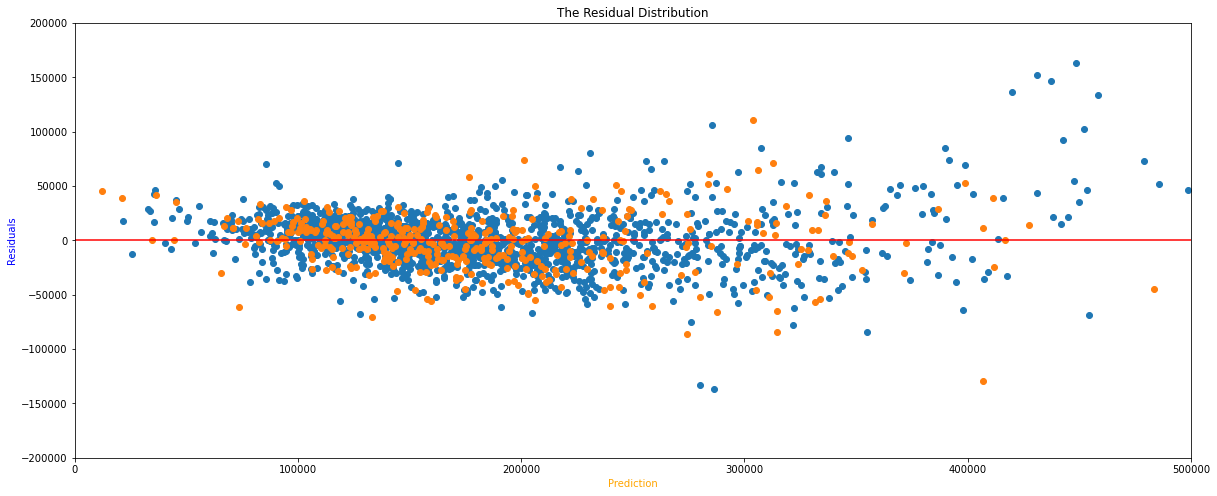

In [293]:
plt.figure(figsize = (20, 8))
plt.scatter(train_pred, train_res)
plt.scatter(val_pred, val_res)
plt.axhline(0, color='red')
plt.title('The Residual Distribution')
plt.xlabel('Prediction', c = 'orange')
plt.ylabel('Residuals', c = 'blue')
plt.xlim(0, 500000)
plt.ylim(-200000, 200000)
plt.savefig('./images/lr__toge_residual_scatter.jpg');

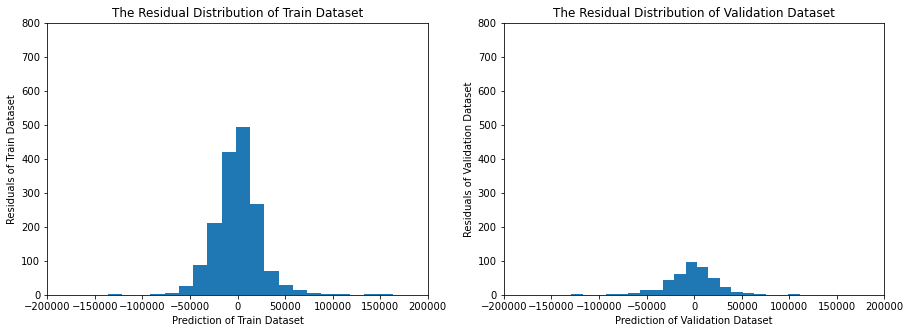

In [255]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.hist(train_res, bins = 20)
plt.title('The Residual Distribution of Train Dataset')
plt.xlabel('Prediction of Train Dataset')
plt.ylabel('Residuals of Train Dataset')
plt.xlim(-200000, 200000)
plt.ylim(0, 800)

plt.subplot(1, 2, 2)
plt.hist(val_res, bins = 20)
plt.title('The Residual Distribution of Validation Dataset')
plt.xlabel('Prediction of Validation Dataset')
plt.ylabel('Residuals of Validation Dataset')
plt.xlim(-200000, 200000)
plt.ylim(0, 800);
plt.savefig('./images/lr_residual_hist.jpg');

In [256]:
lr.intercept_

181718.52743902436

In [257]:
coef = pd.DataFrame(list(zip(lr.feature_names_in_, lr.coef_)))
coef.columns = ['parameter', 'coefficient']
coef = coef.sort_values(by = 'coefficient')

coef.to_csv('./datasets/lr_coef.csv', index = False)

In [258]:
coef.head()

,parameter,coefficient
23,bldg_type_TwnhsE,-8128.094567
22,bldg_type_Twnhs,-5421.709342
107,house_age_built,-4320.928476
55,garage_finish_RFn,-3799.617902
108,house_age_remodel,-3704.545572


In [259]:
coef.tail()

,parameter,coefficient
33,roof_matl_WdShngl,27326.923440
31,roof_matl_Tar&Grv,45824.781363
29,roof_matl_CompShg,62223.536364
64,misc_feature_Shed,78642.628915
62,misc_feature_NA,84419.069285


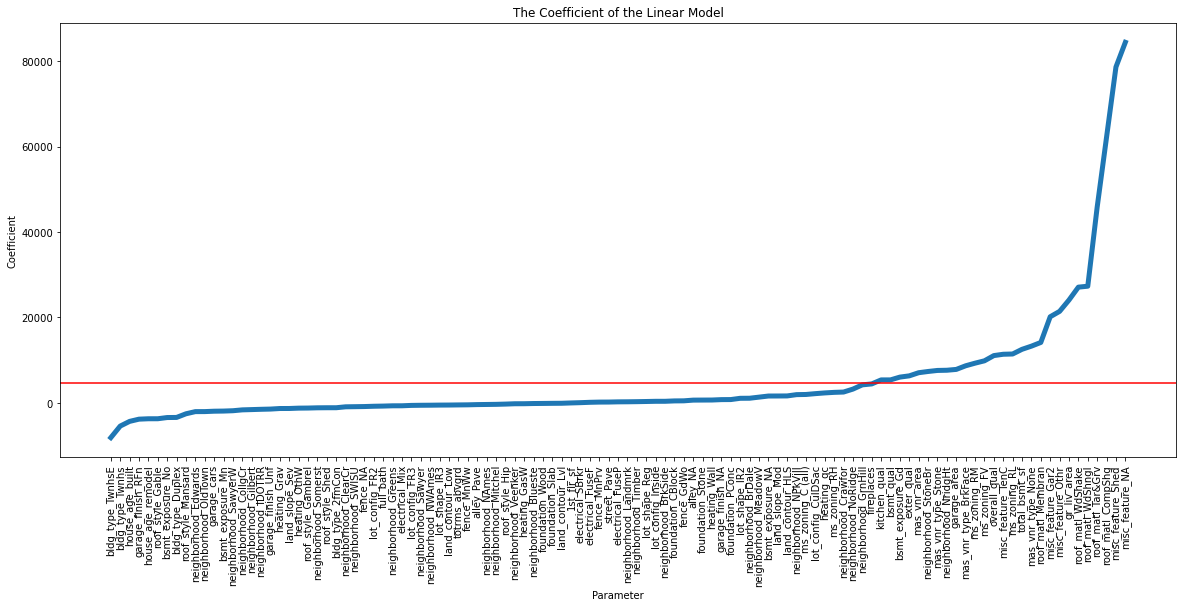

In [260]:
plt.figure(figsize = (20,8))
sns.lineplot(data = coef, x = 'parameter', y = 'coefficient', lw = 5)
plt.axhline(coef['coefficient'].mean(), color='red')
plt.xticks(rotation = 90);
plt.title('The Coefficient of the Linear Model')
plt.xlabel('Parameter')
plt.ylabel('Coefficient');
plt.savefig('./images/lr_coefficient.jpg');

In [261]:
train_pred_df = pd.DataFrame(train_pred)
train_pred_df.columns = ['predicted_price']

val_pred_df = pd.DataFrame(val_pred)
val_pred_df.columns = ['predicted_price']

test_pred_df = pd.DataFrame(test_pred)
test_pred_df.columns = ['predicted_price']

In [262]:
# Add id column
lr_train_pred = pd.concat([train_id, train_pred_df], axis = 1)
lr_val_pred = pd.concat([val_id, val_pred_df], axis = 1)
lr_test_pred = pd.concat([test_id, test_pred_df], axis = 1)

In [263]:
lr_test_pred.columns = ['Id', 'SalePrice']
lr_test_pred.to_csv('./datasets/submission_lr.csv', index = False)

## 4. Ridge and Lasso

### 4.1. Ridge

In [264]:
ridge = RidgeCV(alphas = np.logspace(0, 5, 200))

In [265]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]))

In [266]:
ridge.alpha_

258.2618760682677

In [267]:
ridge.score(X_train, y_train), ridge.score(X_val, y_val)

(0.8775559465681877, 0.8761843211741213)

In [268]:
metrics.mean_squared_error(y_train, ridge.predict(X_train)) ** 0.5, metrics.mean_squared_error(y_val, ridge.predict(X_val)) ** 0.5

(27912.806245618794, 27122.919719812977)

In [269]:
rg_train_pred = ridge.predict(X_train)
rg_train_pred = pd.DataFrame(rg_train_pred, columns = ['SalePrice'])

rg_val_pred = ridge.predict(X_val)
rg_val_pred = pd.DataFrame(rg_val_pred, columns = ['SalePrice'])

rg_test_pred = ridge.predict(test)
rg_test_pred = pd.DataFrame(rg_test_pred, columns = ['SalePrice'])

In [270]:
rg_res = y_val - ridge.predict(X_val)

In [271]:
rg_test_pred.insert(loc = 0, column = 'Id', value = test_id)
rg_test_pred

,Id,SalePrice
0,2658,133191.407451
1,2718,177438.518592
2,2414,200095.529781
3,1989,125174.264782
4,625,175755.476140
...,...,...
873,1662,174368.865095
874,1234,214507.517457
875,1373,139200.430374
876,1672,107554.390828


In [272]:
rg_test_pred.to_csv('./datasets/submission_ridge.csv', index = False)

### 4.2. Lasso

In [273]:
lasso = LassoCV(alphas = np.arange(0.001, 10, 1), max_iter = 10000)

In [274]:
lasso.fit(X_train, y_train)

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]),
        max_iter=10000)

In [275]:
lasso.alpha_

9.000999999999998

In [276]:
lasso.score(X_train, y_train), lasso.score(X_val, y_val)

(0.90836178244172, 0.8882049886438458)

In [277]:
metrics.mean_squared_error(y_train, lasso.predict(X_train)) ** 0.5, metrics.mean_squared_error(y_val, lasso.predict(X_val)) ** 0.5

(24147.544132794945, 25772.69470019477)

In [278]:
cross_val_score(lasso, X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9888182675.118042, tolerance: 688738455.3754988
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26985185805.67932, tolerance: 695549778.5076067
  model = cd_fast.enet_coordinate_descent_gram(


array([0.89115556, 0.71115088, 0.78090333, 0.81877005, 0.69996591])

In [279]:
ls_train_pred = lasso.predict(X_train)
ls_train_pred = pd.DataFrame(ls_train_pred, columns = ['SalePrice'])

ls_val_pred = lasso.predict(X_val)
ls_val_pred = pd.DataFrame(ls_val_pred, columns = ['SalePrice'])

ls_test_pred = lasso.predict(test)
ls_test_pred = pd.DataFrame(ls_test_pred, columns = ['SalePrice'])

In [280]:
ls_test_pred.insert(loc = 0, column = 'Id', value = test_id)
ls_test_pred

,Id,SalePrice
0,2658,143461.213320
1,2718,186010.372211
2,2414,193105.814513
3,1989,120780.838840
4,625,175837.210304
...,...,...
873,1662,177602.198301
874,1234,216473.843325
875,1373,144069.875501
876,1672,104669.320453


In [281]:
ls_test_pred.to_csv('./datasets/submission_lasso.csv', index = False)

In [282]:
ls_res = y_val - lasso.predict(X_val)

Ridge and Lasso did not enhance the accuracy of the original model. 

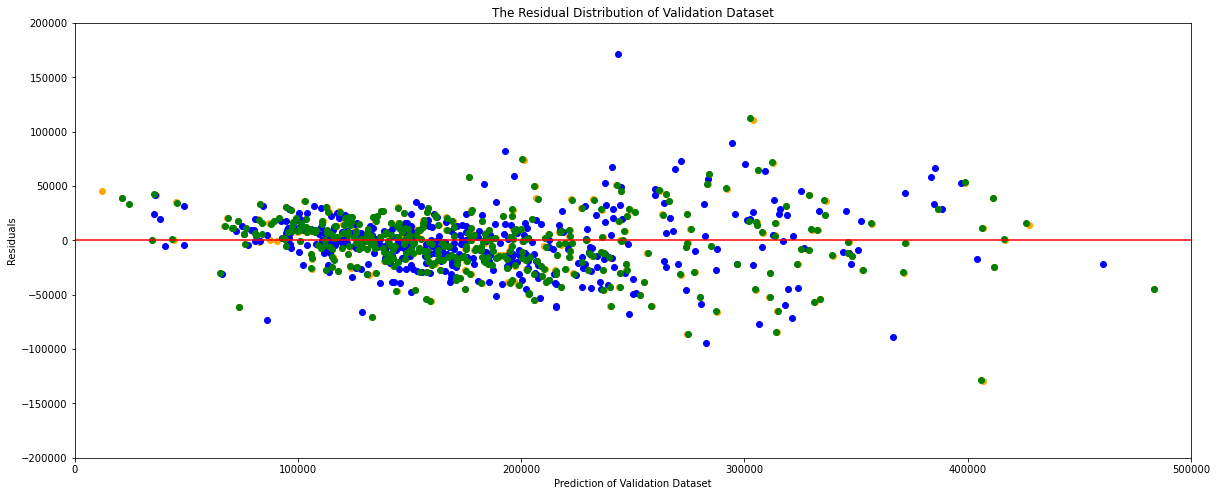

In [288]:
plt.figure(figsize = (20, 8))

plt.scatter(val_pred, val_res, c = 'orange')
plt.scatter(ridge.predict(X_val), rg_res, c = 'blue')
plt.scatter(lasso.predict(X_val), ls_res, c = 'green')
plt.axhline(0, color='red')
plt.title('The Residual Distribution of Validation Dataset')
plt.xlabel('Prediction of Validation Dataset')
plt.ylabel('Residuals')
plt.xlim(0, 500000)
plt.ylim(-200000, 200000)
plt.savefig('./images/vaild_res.jpg');